In [1]:
import sys
functions_at = '/proj/scripts/functions'
sys.path = [f'{functions_at}'] + sys.path
from functions import *
tmp_at = '/proj/tmp_data'
dump_at = '/proj/dump'
source_data = '/proj/source_data/Training_Data'
source_data_2 = '/proj/source_data/Testing_Data'
processed_data = '/proj/processed_data'

In [2]:
## trait_data
trait_data = pd.read_csv(f"{source_data}/1_Training_Trait_Data_2014_2021.csv")
## meta data
meta_data = pd.read_csv(f"{source_data}/2_Training_Meta_Data_2014_2021_utf_encoded.csv").add_prefix("mt_dta_")
## geno data
geno_data = pd.read_csv(f"{processed_data}/geno_processed.miss.1.mac.1.biallelic.txt").add_prefix("ge_dta_")
## soil data
soil_data = pd.read_csv(f"{source_data}/3_Training_Soil_Data_2015_2021.csv").add_prefix("sl_dta_")
## weather data
weather_data = pd.read_csv(f"{source_data}/4_Training_Weather_Data_2014_2021.csv").add_prefix("wt_dta_")
## EC data
ec_data = pd.read_csv(f"{source_data}/6_Training_EC_Data_2014_2021.csv").add_prefix("ec_dta_")
# testing data to be provided
submission_data = pd.read_csv(f"{source_data_2}/1_Submission_Template_2022.csv")

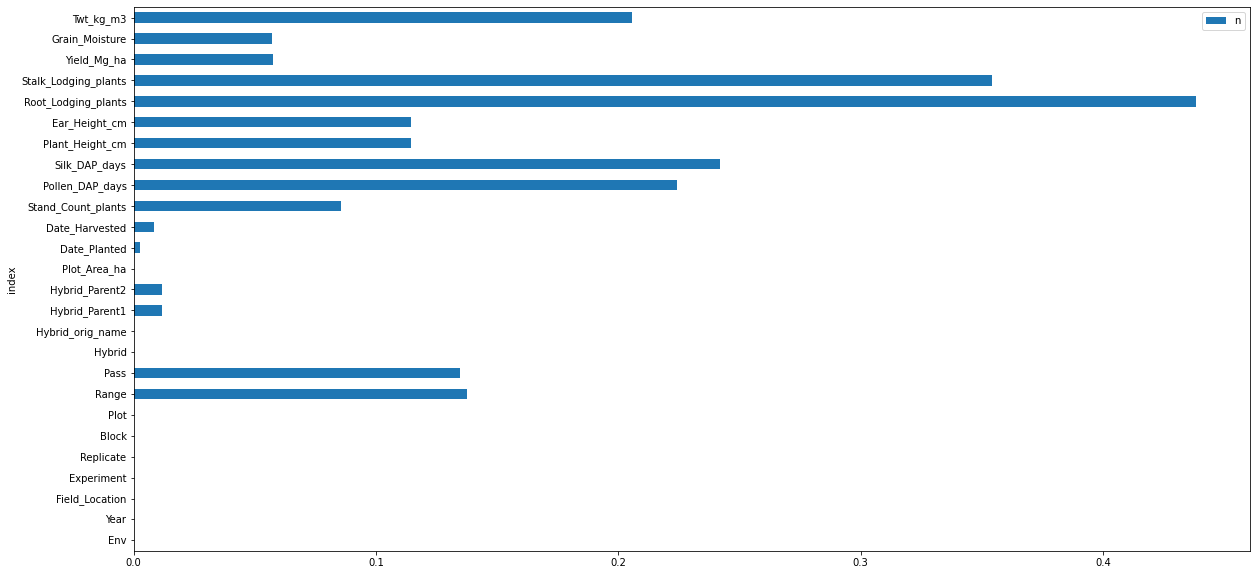

In [3]:
# pheno data overview
pheno_missing = trait_data.isna().sum()/trait_data.shape[0]
pheno_missing.reset_index(name="n").plot.barh(x='index', y='n',figsize=(20, 10)) # there are also missing values in traits to be predicted i.e. Yield_Mg_ha. I will not filter here so that you can decide this for your model later.

# remove objects to free memory
del pheno_missing

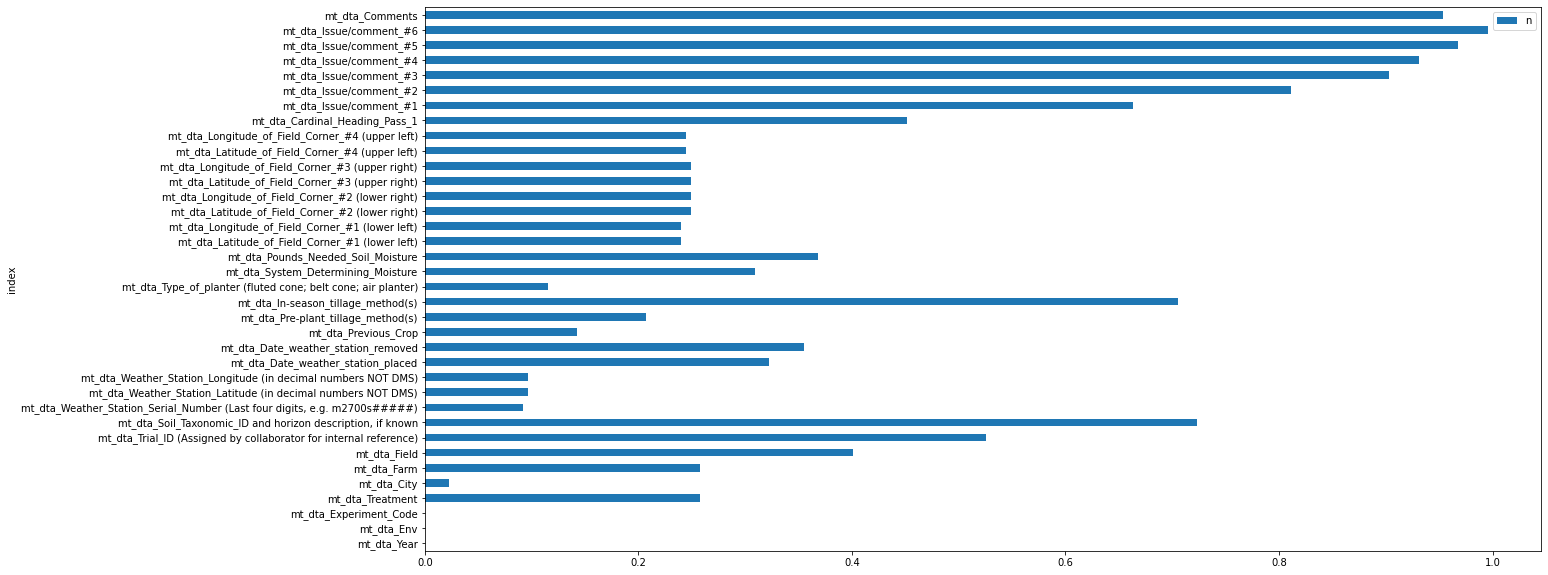

In [4]:
# meta data overview
meta_missing = meta_data.isna().sum()/meta_data.shape[0]
meta_missing.reset_index(name="n").plot.barh(x='index', y='n',figsize=(20, 10)) # except three columns, all (variable) columns have some missing data. I don't think meta data is useful for regression

# remove objects to free memory
del meta_missing

In [5]:
# geno data overview
geno_missing = geno_data.isna().sum()/geno_data.shape[0]
np.ptp(geno_missing.values) # no missing

# check overlap of geno-pheno data
trait_data["geno_overlap"] = trait_data.Hybrid.isin(geno_data.ge_dta_Hybrid).astype(int)
print(f'{trait_data.shape[0] - sum(trait_data["geno_overlap"])} rows corresponding to {trait_data.loc[trait_data["geno_overlap"] == 0, "Hybrid"].nunique()} hybrids are without genotypic data. These will be excluded before merging the data together.')

# remove those rows whose geno data is absent
trait_data_subset_geno = trait_data.loc[trait_data["geno_overlap"] == 1, :].drop(["geno_overlap"], axis = 1)
trait_data_subset_geno = trait_data_subset_geno.loc[:,~trait_data_subset_geno.columns.str.contains('overlap', case=False)] #remove the ovelap column

# merge genodata
pheno_geno_data = pd.merge(trait_data_subset_geno, geno_data, how="left", left_on="Hybrid", right_on="ge_dta_Hybrid")

# delete redundant objects to free memory
del trait_data
del trait_data_subset_geno
del geno_missing
del geno_data

4579 rows corresponding to 260 hybrids are without genotypic data. These will be excluded before merging the data together.


39386 rows corresponding to 76 Env are without soil data. These will not be excluded at excluded at this stage, but after merging these will include missing values to the phenodata.


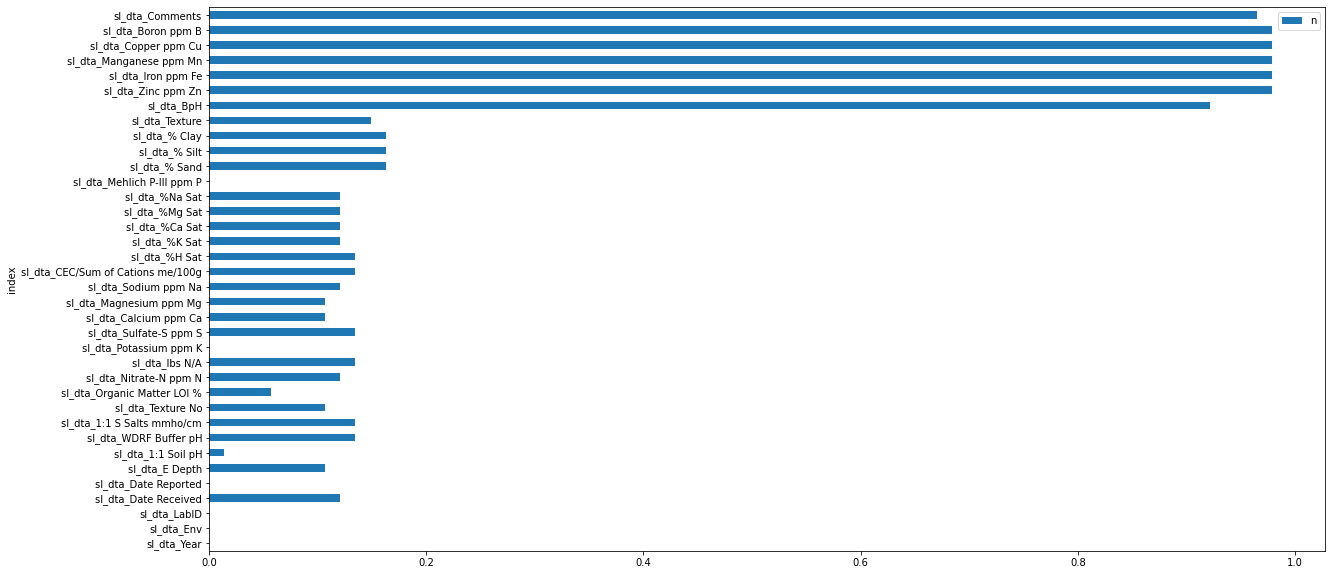

In [7]:
# soil_data overview
soil_missing = soil_data.isna().sum()/soil_data.shape[0]
soil_missing.reset_index(name="n").plot.barh(x='index', y='n',figsize=(20, 10)) # the columns with > 20 % values will be deleted. there are non numeric values in this data.
to_include = soil_missing[soil_missing <= 0.2].index.values
soil_data_subset = soil_data.loc[:, to_include]

# check overlap of soil-pheno data
pheno_geno_data["soil_overlap"] = pheno_geno_data.Env.isin(soil_data_subset.sl_dta_Env).astype(int)
print(f'{pheno_geno_data.shape[0] - sum(pheno_geno_data["soil_overlap"])} rows corresponding to {pheno_geno_data.loc[pheno_geno_data["soil_overlap"] == 0, "Env"].nunique()} Env are without soil data. These will not be excluded at excluded at this stage, but after merging these will include missing values to the phenodata.')

# merge soildata
pheno_geno_soil_data = pd.merge(pheno_geno_data, soil_data_subset, how="left", left_on="Env", right_on="sl_dta_Env")

# remove redundant objects to free up memory
del soil_missing
del to_include
del soil_data_subset
del pheno_geno_data

In [8]:
# weather data reshape
weather_data.groupby(["wt_dta_Env"])["wt_dta_Env"].count()
weather_data["wt_dta_moth_dy"] = weather_data["wt_dta_Date"].astype(str).str[4:8]
weather_data_wide = weather_data.pivot(index="wt_dta_Env", columns="wt_dta_moth_dy", values=weather_data.columns.tolist()[2:-1])
weather_data_wide.columns = ['_'.join(map(str, x)) for x in weather_data_wide.columns] #212 * (16*366)

# weather data overview 
weather_missing = weather_data_wide.isna().sum()
weather_missing[weather_missing > 0] # all leap years have missing values, 0229 stands for 29 feb. I will not remove these, but you can.

# check overlap
pheno_geno_soil_data["env_overlap"] = pheno_geno_soil_data.Env.isin(weather_data_wide.index).astype(int)
print(f'{pheno_geno_soil_data.shape[0] - sum(pheno_geno_soil_data["env_overlap"])} rows corresponding to {pheno_geno_soil_data.loc[pheno_geno_soil_data["env_overlap"] == 0, "Env"].nunique()} Env are without weather data. These will not be excluded at excluded at this stage, but after merging these will include missing values to the phenodata. I will look if online sources can substitute fot his missing env data')
pheno_geno_soil_data = pheno_geno_soil_data.loc[:,~pheno_geno_soil_data.columns.str.contains('overlap', case=False)] #remove the ovelap column

## merge weather_data
pheno_geno_soil_env_data = pd.merge(pheno_geno_soil_data, weather_data_wide, how="left", left_on="Env", right_on="wt_dta_Env")

# remove redundant data to free memory
del weather_data
del weather_data_wide
del weather_missing
del pheno_geno_soil_data

2125 rows corresponding to 5 Env are without weather data. These will not be excluded at excluded at this stage, but after merging these will include missing values to the phenodata. I will look if online sources can substitute fot his missing env data


In [9]:
## EC data overview
ec_missing = ec_data.isna().sum()/ec_data.shape[0]
np.ptp(ec_missing.values) # no missing

# check overlap
pheno_geno_soil_env_data["ec_overlap"] = pheno_geno_soil_env_data.Env.isin(ec_data.ec_dta_Env).astype(int)
print(f'{pheno_geno_soil_env_data.shape[0] - sum(pheno_geno_soil_env_data["ec_overlap"])} rows corresponding to {pheno_geno_soil_env_data.loc[pheno_geno_soil_env_data["ec_overlap"] == 0, "Env"].nunique()} Env are without weather data. These will not be excluded at excluded at this stage. If we decide to use ECs then we need to drop  env data here')
pheno_geno_soil_env_data = pheno_geno_soil_env_data.loc[:,~pheno_geno_soil_env_data.columns.str.contains('overlap', case=False)] #remove the ovelap column

## merge weather_data
pheno_geno_soil_env_ec_data = pd.merge(pheno_geno_soil_env_data, ec_data, how="left", left_on="Env", right_on="ec_dta_Env")

# remove redundant data to free data
del ec_missing
del pheno_geno_soil_env_data

32013 rows corresponding to 52 Env are without weather data. These will not be excluded at excluded at this stage. If we decide to use ECs then we need to drop  env data here


In [ ]:
pheno_geno_soil_env_ec_data.to_csv(f"{processed_data}/combined_mat.csv", index = False)

In [6]:
# assuming that we arrive on object called final_data after filtereing and if needed some imputation

final_data = pheno_geno_data.loc[:, ['Env', 'Year', "Hybrid"]]

In [7]:
# create train test splits and save them V_1

fold = 10
runs = 100
run = 0
out_dict_1 = {}
while run < runs:
    out_dict_2 = {}
    if run > 0:
        del kf
    kf = KFold(n_splits=fold, random_state=40+(20*run), shuffle=True)
    fold = 0
    for train_index, test_index in kf.split(final_data.index):
        in_dict = {}
        in_dict["train"] = train_index.tolist()
        in_dict["test"] = test_index.tolist()
        out_dict_2[fold] = in_dict
        fold += 1
    out_dict_1[run] = out_dict_2
    run += 1
# write json file
# write_json(data = out_dict_1, path = f"{processed_data}/train_test_split.json")

In [8]:
# create train test splits and save them V_2

sets={}
hld_year_geno=[]

total_years = final_data.Year.unique()
for year in total_years:
    for rep in range(0,10):
        # test data
        test_data = final_data[final_data.Year.isin([year])]
        test_geno_total = test_data.Hybrid.unique().tolist()
        test_geno_sub = random.sample(test_geno_total, int(len(test_geno_total)*0.2))
        test_set = test_data[test_data.Hybrid.isin(test_geno_sub)]
        
        # val data
        train_data = final_data[~final_data.Year.isin([year])]
        train_data_sub = train_data[~train_data.Hybrid.isin(test_geno_sub)]
        
        val_idx = sorted(random.sample(train_data_sub.index.tolist(), int(0.1*len(train_data_sub.index.tolist()))))
        val_set = train_data_sub.loc[val_idx].copy()
        
        # train_data
        train_set = train_data_sub[~train_data_sub.index.isin(val_idx)]
        
        # sanity checks
        if len(train_set[train_set["Year"].isin(test_set["Year"].unique().tolist())]) !=0:
            print("CONTAMINATED SETS: Year")
        if len(train_set[train_set["Hybrid"].isin(test_set["Hybrid"].unique().tolist())]) !=0:
            print("CONTAMINATED SETS: Genotype")
            
        # produce output
        sets[str(year)+"@"+str(rep)]={"train":train_set.index.tolist(),
                 "val":val_set.index.tolist(),
                 "test":test_set.index.tolist()}
                #record data for diagnostic purposes
        hld_year_geno.append([year, rep, len(test_set["Hybrid"].unique())/len(test_geno_total),
                              len(train_set["Hybrid"].unique())/len(final_data["Hybrid"].unique()),
                              len(train_set), len(val_set), len(test_set)])
len(sets)
# write json file
write_json(data = sets, path = f"{processed_data}/train_test_split_v2.json") # can think of saving the hld_year_geno also if needed

Done


In [9]:
#todo: create train test splits and save them V_3

#geno_per_env_cutoff=0
genos_per_Env = final_data.pivot_table(index="Env", values="Hybrid", 
                                               aggfunc=lambda x: np.count_nonzero(np.unique(x))).sort_values("Hybrid")
genos_per_Env.reset_index(inplace=True)
print(len(genos_per_Env))

217
